# Tomograf

155910 Katarzyna Jaromirska \
155898 Łukasz Grobelny

### Importy

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from skimage.draw import line_nd
from skimage.util import img_as_ubyte, img_as_float64
import glob
import ipywidgets as widgets
from IPython.display import display, HTML
import pydicom
import random
import datetime
import re

%matplotlib inline

### Wczytanie obrazu

In [2]:
def load_image(file):
    if file.endswith(".dcm"):
        dcm = pydicom.dcmread(file)
        return dcm.pixel_array.astype(np.uint8)
    else:
        return io.imread(file, as_gray=True)

### Algorytm Bresenhama

In [3]:
def bresenham(x0, y0, x1, y1):
    points = []
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((y0, x0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

### Zmiana wielkości obrazu

In [4]:
def resize_image(image):
    a, b = image.shape
    if a == b:
        return image
    
    size = max(a, b)
    resized_image = np.zeros((size, size), dtype=image.dtype)

    start_x = (size - a) // 2
    start_y = (size - b) // 2

    resized_image[start_x:start_x + a, start_y:start_y + b] = image
    return resized_image

In [5]:
def size_back(resized_image, original_size):
    size = resized_image.shape[0]

    start_x = (size - original_size[0]) // 2
    start_y = (size - original_size[1]) // 2

    original_image = resized_image[start_x:start_x + original_size[0], start_y:start_y + original_size[1]]

    return original_image

### Normalizacja wartości obrazu

In [6]:
def normalize_image(image):
    image = np.maximum(image, 0)
    max_val = np.quantile(image, 0.999)
    image = np.clip(image / max_val, 0, 1) if max_val > 0 else np.zeros_like(image)
    return image

# Transformata Radona

In [7]:
def radon_transform(image, detectors = 180, detectors_angular_span = 180, step = 1):
    image_center = (image.shape[0] // 2, image.shape[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    emiter_angles = np.deg2rad(np.arange(0, 360, step))
    radon_image = np.zeros((len(emiter_angles), detectors), dtype=image.dtype)

    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i, angle in enumerate(emiter_angles):
        emiter_pos = (int(image_radius * np.cos(angle) + image_center[0]), 
                      int(image_radius * np.sin(angle) + image_center[1]))

        for j in range(detectors):
            detector_pos = (int(image_radius * (np.cos(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0]),
                            int(image_radius * (np.sin(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1]))

            line_pixels = bresenham(emiter_pos[0], emiter_pos[1], detector_pos[0], detector_pos[1])
            
            valid_pixels = [(y, x) for y, x in line_pixels if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]]

            if valid_pixels:
                radon_image[i, j] = np.mean([image[y, x] for y, x in valid_pixels])

    return radon_image

# Odwrócona transformata Radona

In [8]:
inverse_image_steps = []

def inverse_radon_transform(image, image_size, detectors_angular_span = 180, step = 1):
    global inverse_image_steps
    inverse_image_steps = []
    reconstructed_image = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    
    # get scans/detectors from image
    scans = image.shape[0]
    detectors = image.shape[1]

    image_center = (image_size[0] // 2, image_size[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    emiter_angles = np.deg2rad(np.arange(0, 360, step))
    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i, angle in enumerate(emiter_angles):
        emiter_pos = (int(image_radius * np.cos(angle) + image_center[0]), 
                        int(image_radius * np.sin(angle) + image_center[1]))

        for j in range(detectors):
            detector_pos = (int(image_radius * (np.cos(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0]),
                            int(image_radius * (np.sin(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1]))

            line_pixels = bresenham(emiter_pos[0], emiter_pos[1], detector_pos[0], detector_pos[1])

            valid_pixels = [(y, x) for y, x in line_pixels if 0 <= y < image_size[0] and 0 <= x < image_size[1]]
            if valid_pixels:
                rows, cols = zip(*valid_pixels)
                reconstructed_image[rows, cols] += image[i, j] #/ len(valid_pixels)
        inverse_image_steps.append(normalize_image(reconstructed_image))

    return reconstructed_image

# Filtr sinogramu

In [9]:
def filter_sinogram(image, kernel_size=21):
    # make it odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    kernel = np.zeros(kernel_size)
    kernel_center = kernel_size // 2
    kernel[kernel_center] = 1
    for i in range(kernel_center + 1, kernel_size, 2):
        val = (-4 / np.pi**2) / (i - kernel_center)**2
        kernel[i] = val
        kernel[-(i + 1)] = val

    filtered_image = np.zeros((image.shape[0], image.shape[1]), dtype=image.dtype)
    for i in range(image.shape[0]):
        filtered_image[i, :] = np.convolve(image[i, :], kernel, mode='same')
    return filtered_image

### Błąd średniokwadratowy

In [10]:
def rmse(image_in, image_out):
    return (np.mean(image_in - image_out)**2)**0.5

## Zapis pliku DICOM

In [11]:
def save_DICOM(image, patient_id: str, patient_name: str, birth_date, sex:str, study_date, body_part:str, comment="Check-up", filename="saved_dicom"):
    filename += ".dcm"
    ds = pydicom.Dataset()

    ds.PatientName = patient_name
    ds.PatientID = str(patient_id)
    ds.PatientSex = 'M'
    ds.PatientBirthDate = birth_date
    
    age = study_date.year - birth_date.year - ((study_date.month, study_date.day) < (birth_date.month, birth_date.day))
    ds.PatientAge = f"{age:03}Y"

    ds.BodyPartExamined = body_part
    ds.Modality = "CT"
    ds.StudyDate = study_date
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = pydicom.uid.CTImageStorage
    ds.ImageType = ["ORIGINAL", "PRIMARY", "AXIAL"]
    ds.InstanceNumber = str(random.randint(1, 100))
    ds.ImagesInAcquisition = "1"
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.Rows, ds.Columns = image.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = (image.astype(np.uint16)).tobytes()

    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = pydicom.uid.generate_uid()
    file_meta.ImplementationVersionName = "PYDICOM 2.0.0"

    ds.file_meta = file_meta

    ds.ImageComments = comment

    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.save_as(filename, write_like_original=False)

# Interaktywne tworzenie tomografu

In [12]:
# global variables
filename = ""
detectors = 180
detectors_angular_span = 180
step = 1

is_filter = True

in_image = None
out_nonfiltered_image = None
out_filtered_image = None
sinogram = None

def set_parameters(f, d, arch, i):
    global filename, scans, detectors, detectors_angular_span, step
    filename = f
    detectors = d
    detectors_angular_span = arch
    step = i

def set_is_filter(val):
    global is_filter
    is_filter = val

### Tworzenie wykresów

In [13]:
def show_plot(arg):
    global out_nonfiltered_image, in_image, sinogram, out_filtered_image
    in_image = None

    if re.match(r".*.dcm", filename):
        dcm_file = pydicom.dcmread(filename)
        in_image = dcm_file.pixel_array.astype(np.ubyte)
        in_image = img_as_ubyte(in_image)
    else:
        in_image = io.imread(filename)
        in_image = img_as_ubyte(in_image)

    if in_image.ndim == 3:
        in_image = in_image[..., 0]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(in_image, cmap='gray')
    plt.title("Image")
    plt.axis("off")
    plt.show()
    
    original_size = in_image.shape
    image = resize_image(in_image)
    
    # sinogram / inversed sinogram basic
    sinogram = radon_transform(image, detectors=detectors, detectors_angular_span=detectors_angular_span, step=step)
    inversed_sinogram = inverse_radon_transform(sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
    inversed_sinogram = size_back(inversed_sinogram, original_size)
    inversed_sinogram = normalize_image(inversed_sinogram)
    out_nonfiltered_image = inversed_sinogram
    
    # plots
    if is_filter:
        filtered_sinogram = filter_sinogram(img_as_float64(sinogram))
        inversed_filtered_sinogram = inverse_radon_transform(filtered_sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
        inversed_filtered_sinogram = size_back(inversed_filtered_sinogram, original_size)
        inversed_filtered_sinogram = normalize_image(inversed_filtered_sinogram)
        out_filtered_image = inversed_filtered_sinogram

        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        axes[0, 0].imshow(sinogram, cmap='gray')
        axes[0, 0].set_title("Sinogram (no filter)")

        axes[0, 1].imshow(filtered_sinogram, cmap='gray')
        axes[0, 1].set_title("Filtered sinogram")

        axes[1, 0].imshow(inversed_sinogram, cmap='gray')
        axes[1, 0].set_title("Inversed sinogram (no filter)")

        axes[1, 1].imshow(inversed_filtered_sinogram, cmap='gray')
        axes[1, 1].set_title("Inversed sinogram (filter)")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(sinogram, cmap='gray')
        axes[0].set_title("Sinogram (bez filtra)")

        axes[1].imshow(inversed_sinogram, cmap='gray')
        axes[1].set_title("Rekonstrukcja (bez filtra)")

    for ax in fig.axes:
        ax.axis("off")

    plt.show()

    # out_image = inversed_filtered_sinogram if is_filter else inversed_sinogram

# Interaktywny wybór parametrów i zdjęcia

interactive(children=(Dropdown(description='Filename', index=3, layout=Layout(width='80%'), options=('.\\image…

interactive(children=(Checkbox(value=True, description='Sinogram filtering'), Output()), _dom_classes=('widget…

Button(description='Show results', style=ButtonStyle())

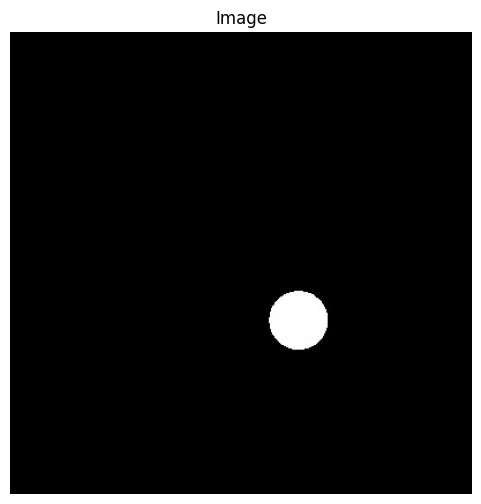

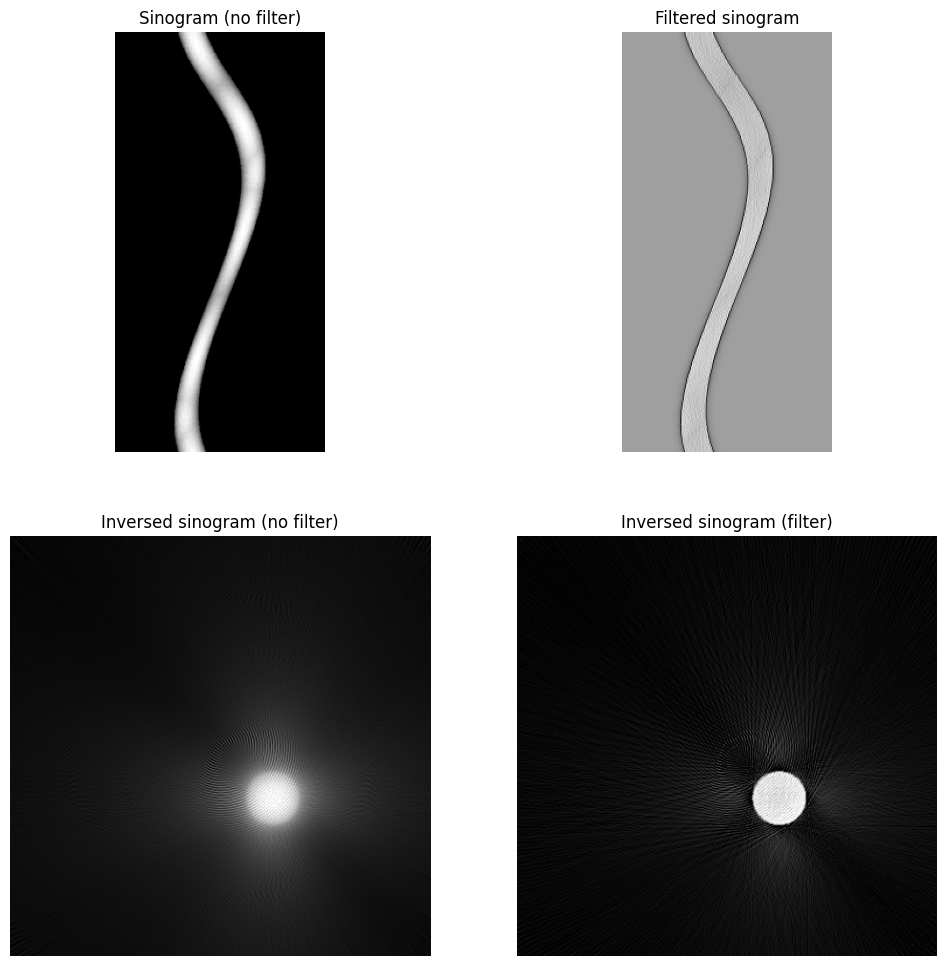

In [ ]:
filenames = glob.glob(".\\images\\*.jpg") + glob.glob(".\\dicom\\*.dcm")

widgets.interact(set_parameters,
         f=widgets.Dropdown(options=filenames, value='.\\images\\Kropka.jpg', description='Filename', layout=widgets.Layout(width='80%'), style={'description_width': '200px'}),
         d=widgets.IntSlider(value=180, min=90, max=720, step=30, description='Amount of detectors:', layout=widgets.Layout(width='80%'), style={'description_width': '200px'}),
         arch=widgets.IntSlider(value=180, min=90, max=360, step=10, description='Detectors angular span:', layout=widgets.Layout(width='80%'), style={'description_width': '200px'}),
         i=widgets.IntSlider(value=2, min=1, max=10, step=1, description='Emiter-detectors rotate steps:', layout=widgets.Layout(width='80%'), style={'description_width': '200px'})
)

widgets.interact(set_is_filter, val=widgets.Checkbox(value=True, description='Sinogram filtering'))

button = widgets.Button(description="Show results")
button.on_click(show_plot)

display(button)

## Iteracja po krokach

In [ ]:
import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 80 

def animate_sinogram():
    fig, ax = plt.subplots(figsize=(6, 6))
    sinogram_plt = ax.imshow(np.zeros_like(sinogram), cmap='gray', vmin=0, vmax=32)
    ax.set_title("Sinogram")
    ax.axis("off")

    def update(frame):
        sinogram_plt.set_data(sinogram[:frame+1, :])
        return sinogram_plt,

    num_frames = sinogram.shape[0]
    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)
    plt.close(fig)
    return anim.to_jshtml()


def animate_reconstruction():
    fig, ax = plt.subplots(figsize=(6, 6))
    reconstruction_plt = ax.imshow(np.zeros_like(inverse_image_steps[0]), cmap='gray', vmin=0, vmax=1)
    ax.set_title("Reconstructed Image")
    ax.axis("off")

    def update(frame):
        reconstruction_plt.set_data(inverse_image_steps[frame])
        return reconstruction_plt,

    num_frames = len(inverse_image_steps)
    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)
    plt.close(fig)
    return anim.to_jshtml()


global sinogram, inverse_image_steps

display(HTML(animate_sinogram()))
display(HTML(animate_reconstruction()))

## Zapis wyniku jako DICOM

In [ ]:
patient_id = 0
patient_name = ''
patient_sex = ''
patient_birth_date = datetime.date.today()
patient_study_date = datetime.date.today()
patient_body_part = ''
patient_comment = ''
filename_dicom = ''

def set_dicom_params(id, name, sex, birth, exam, body_part, comment, filename):
    global patient_id, patient_name, patient_sex, patient_birth_date, patient_study_date, patient_body_part, patient_comment, filename_dicom
    patient_id = str(id)
    patient_name = name
    patient_sex = sex
    patient_birth_date = birth
    patient_study_date = exam
    patient_body_part = body_part
    patient_comment = comment
    filename_dicom = filename

def on_save_cliked(arg):
    if is_filter:
        save_DICOM(img_as_ubyte(out_filtered_image), patient_id, patient_name, patient_birth_date, patient_sex, patient_study_date, patient_body_part)
    else:
        save_DICOM(img_as_ubyte(out_nonfiltered_image), patient_id, patient_name, patient_birth_date, patient_sex, patient_study_date, patient_body_part)



In [ ]:
widgets.interact(set_dicom_params, 
                 id = widgets.IntText(description="Patient ID:", value=1111111),
                 name = widgets.Text(description="Name and Surname:", value="ABC XYZ"),
                 sex = widgets.Dropdown(description="Sex:", options=['M', 'F'], value='M'),
                 birth = widgets.DatePicker(description="Birth date:", value=datetime.date.today()),
                 exam = widgets.DatePicker(description="Study date:", value=datetime.date.today()),
                 body_part = widgets.Text(description="Body part:", value="HEAD"),
                 comment = widgets.Text(description="Comment:", value="Check-up"),
                 filename = widgets.Text(description="Filename (without extension)", value="saved_dicom"))

button = widgets.Button(description="Save as DICOM")
button.on_click(on_save_cliked)

display(button)

interactive(children=(IntText(value=1111111, description='Patient ID:'), Text(value='ABC XYZ', description='Na…

Button(description='Save as DICOM', style=ButtonStyle())

## Sprawdź błąd RMSE

In [19]:
print("Błąd średniokwadratowy - {:6f}".format(rmse(in_image, out_filtered_image if is_filter else out_nonfiltered_image)))

Błąd średniokwadratowy - 3.193037


# Analiza

## Zmiana błędu średniokwadratowego po kolejnych iteracjach

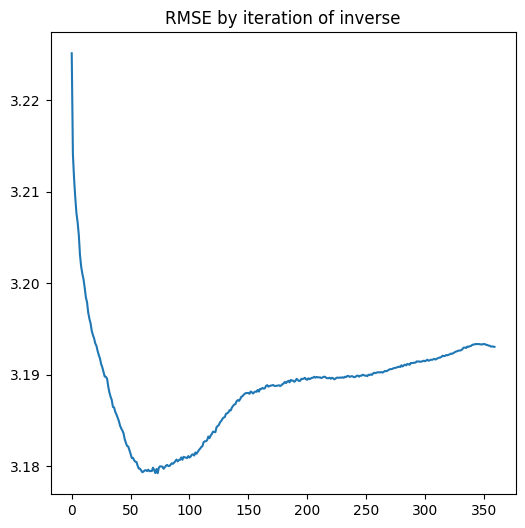

In [20]:
# jesli zaznaczone było filtrowanie to ten sinogram będzie sprawdzany
results = []
for iteration in inverse_image_steps:
    results.append(rmse(in_image, iteration))

plt.figure(figsize=(6, 6))
plt.plot(results)
plt.title("RMSE by iteration of inverse")
plt.show()

## Różnica RMSE pomiędzy użyciem sinogramu z filtrem vs bez filtra

In [21]:
print("Błąd średniokwadratowy (bez filtra) - {:6f}".format(rmse(in_image, out_nonfiltered_image)))
print("Błąd średniokwadratowy (filtr) - {:6f}".format(rmse(in_image, out_filtered_image)))

Błąd średniokwadratowy (bez filtra) - 3.147209
Błąd średniokwadratowy (filtr) - 3.193037


## Zmiana RMSE przy modyfikacji parametrów
Parametry domyślne:
- detektory = 180
- skany = 180
- rozpiętość wachlarza = 180

In [36]:
filename = ".//images//Kropka.jpg"
detectors = 180
detectors_angular_span = 180
step = 1

is_filter = True

in_image = None
out_nonfiltered_image = None
out_filtered_image = None
sinogram = None

in_image = io.imread(filename)
in_image = img_as_ubyte(in_image)

if in_image.ndim == 3:
    in_image = in_image[..., 0]


### Zmiana liczby detektorów

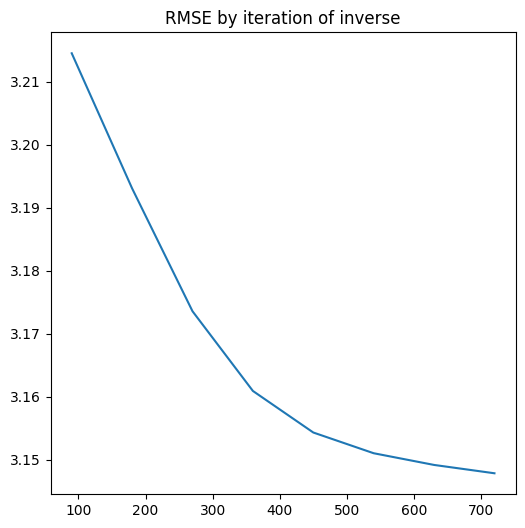

In [ ]:
results = []
detectors_range = range(90, 721, 90)

for d in detectors_range:
    global detectors
    detectors = d

    original_size = in_image.shape
    image = resize_image(in_image)
    
    sinogram = radon_transform(image, detectors=detectors, detectors_angular_span=detectors_angular_span, step=step)
    filtered_sinogram = filter_sinogram(img_as_float64(sinogram))
    inversed_filtered_sinogram = inverse_radon_transform(filtered_sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
    inversed_filtered_sinogram = size_back(inversed_filtered_sinogram, original_size)
    inversed_filtered_sinogram = normalize_image(inversed_filtered_sinogram)
    
    results.append(rmse(in_image, inversed_filtered_sinogram))

plt.figure(figsize=(6, 6))
plt.plot(detectors_range, results)
plt.title("RMSE change depending on number of detector")
plt.show()

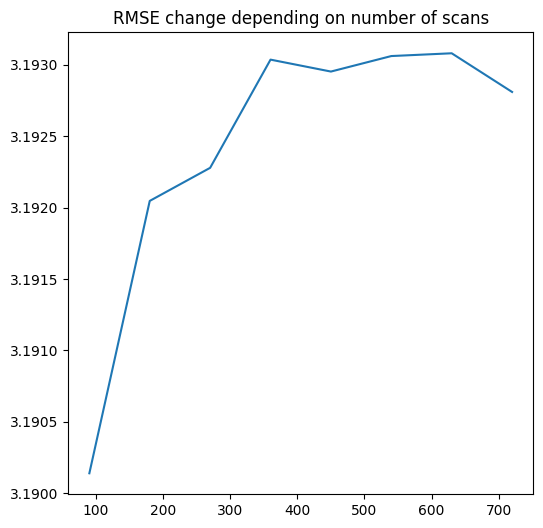

In [35]:
results = []
scans_range = range(90, 721, 90)

for s in scans_range:
    global step
    step = 360/s

    original_size = in_image.shape
    image = resize_image(in_image)
    
    sinogram = radon_transform(image, detectors=detectors, detectors_angular_span=detectors_angular_span, step=step)
    filtered_sinogram = filter_sinogram(img_as_float64(sinogram))
    inversed_filtered_sinogram = inverse_radon_transform(filtered_sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
    inversed_filtered_sinogram = size_back(inversed_filtered_sinogram, original_size)
    inversed_filtered_sinogram = normalize_image(inversed_filtered_sinogram)
    
    results.append(rmse(in_image, inversed_filtered_sinogram))

plt.figure(figsize=(6, 6))
plt.plot(detectors_range, results)
plt.title("RMSE change depending on number of scans")
plt.show()

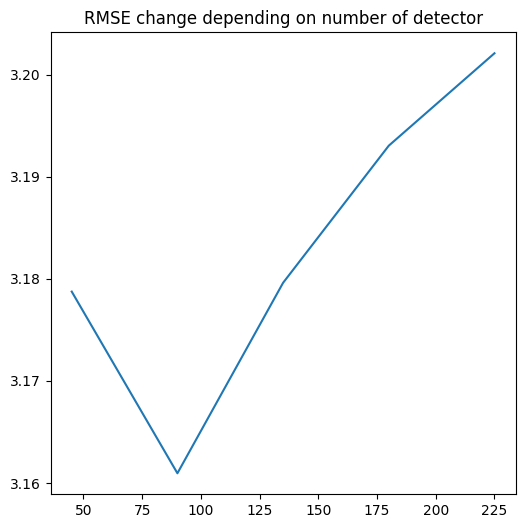

In [38]:
results = []
detectors_span_range = range(45, 270, 45)

for ds in detectors_span_range:
    global detectors_angular_span
    detectors_angular_span = ds

    original_size = in_image.shape
    image = resize_image(in_image)
    
    sinogram = radon_transform(image, detectors=detectors, detectors_angular_span=detectors_angular_span, step=step)
    filtered_sinogram = filter_sinogram(img_as_float64(sinogram))
    inversed_filtered_sinogram = inverse_radon_transform(filtered_sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
    inversed_filtered_sinogram = size_back(inversed_filtered_sinogram, original_size)
    inversed_filtered_sinogram = normalize_image(inversed_filtered_sinogram)
    
    results.append(rmse(in_image, inversed_filtered_sinogram))

plt.figure(figsize=(6, 6))
plt.plot(detectors_span_range, results)
plt.title("RMSE change depending on number of detector")
plt.show()